In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, roc_auc_score, roc_curve, auc, recall_score
import numpy as np
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import plot_confusion_matrix as plot_confusion_matrix_3
from matplotlib.patches import Ellipse

In [2]:
def plot_confusion_matrix(cf_matrix, save_path=None, pixel_level=True, kappa=None, acc=None, y_label='True', x_label='Pred'):
    """ Plots the confusion matrix

    Args:
        cf_matrix: the confusion matrix to plot
        save_path: location where to store the plot
        plot: whether to plot it of save it
        pixel_level: whether to include bg
        kappa: plot kappa as title

    Returns:
        none: saves the figure at the save path

    """

    labels = ['NDBE', 'IND', 'LGD', 'HGD']
    fmt = 'd'

    df_cm = pd.DataFrame(cf_matrix, index=labels, columns=labels)

    plt.figure(figsize=(15, 10))
    plt.rcParams.update({'font.size': 22})
    sns.heatmap(df_cm, annot=True, cmap="Blues", square=True, fmt=fmt)
    plt.gca().set_yticklabels(labels=labels, va='center')
    plt.gca().set_ylabel(y_label, labelpad=30)
    plt.gca().set_xlabel(x_label, labelpad=30)
    # plt.title('Concordance$=${:.2f}%'.format(acc * 100))
    plt.title('Observer test set \n$(\kappa=${:.2f})'.format(kappa))
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [ ]:
rbe_case_df = pd.read_csv('/data/archief/AMC-data/Barrett/labels/rbe_case_level.csv')
rbe_biopsy_df = pd.read_csv('/data/archief/AMC-data/Barrett/labels/rbe_biopsy_level.csv')

display(rbe_case_df)
display(rbe_biopsy_df)

plt.figure(figsize=(16, 8))
plt.subplot(121)
rbe_case_df.groupby('grade').size().plot(kind='pie', autopct='%.2f', colors=['red', 'yellow', 'cyan'])
plt.title('{} cases'.format(len(rbe_case_df)))
plt.ylabel('')
plt.subplot(122)
rbe_biopsy_df.groupby('grade').size().plot(kind='pie', autopct='%.2f', colors=['red', 'yellow', 'cyan'])
plt.title('{} biopsies'.format(len(rbe_biopsy_df)))
plt.ylabel('')
plt.show()

In [ ]:
len(list(rbe_case_df['case']))

In [ ]:
dysplasia_cases = rbe_case_df.loc[(rbe_case_df['grade'] == 'LGD') | (rbe_case_df['grade'] == 'HGD')]['case']
for l in list(dysplasia_cases):
    print(l)
dysplasia_cases.to_csv('/data/archief/AMC-data/Barrett/labels/dyplasia_cases_rbe_reader_study.csv', index=False)

In [ ]:
rbe_biopsy_df[['case', 'biopsy']] = rbe_biopsy_df['biopsy'].str.split('HE', expand=True)
rbe_biopsy_df['case'] = rbe_biopsy_df['case'].str[:-1]

rbe_biopsy_df.loc[rbe_biopsy_df['case'].isin(dysplasia_cases)]

## Code for generation of CSV's

In [ ]:
overview_path = '/data/archief/AMC-data/Barrett/labels/rbe_overview.csv'
df = pd.read_csv(overview_path)
df.reset_index(inplace=True)
df_biopsy = df.rename(columns = {'index':'id', 'Diagnoses Barrett dataset ': 'grade'})
df_prob = df_biopsy[df_biopsy.grade == 'Problem']
display(df_prob)

In [ ]:
overview_path = '/data/archief/AMC-data/Barrett/labels/rbe_overview.csv'
df = pd.read_csv(overview_path)
df.reset_index(inplace=True)
df_biopsy = df.rename(columns = {'index':'id', 'Diagnoses Barrett dataset ': 'grade'})
df_biopsy = df_biopsy[df_biopsy.grade != 'Problem']
df_biopsy['grade_num'] = df_biopsy['grade'].map({'NDBE': 1, 'LGD': 3, 'HGD': 4})
display(df_biopsy)
df_biopsy.to_csv('/data/archief/AMC-data/Barrett/labels/rbe_biopsy_level.csv', index=False)

In [ ]:
df_biopsy['grade'].value_counts()

## Lets group them by slide

In [ ]:
df_slide = df_biopsy
df_slide['slide'] = df_slide['id'].map(lambda x: str(x)[:-2])
df_slide['biopsy_nr'] = df_slide['id'].map(lambda x: str(x)[-1])
print(df_slide)

In [ ]:
df_slide['max grade'] = df_slide.groupby('slide')['grade_num'].transform('max')
df_slide = df_slide.drop_duplicates(subset=['slide'])
df_slide = df_slide.drop_duplicates(subset=['slide'])[['slide', 'max grade']]
df_slide = df_slide.rename(columns={'max grade': 'grade_num'})
df_slide['grade'] = df_slide['grade_num'].map({1:'NDBE', 3: 'LGD', 4: 'HGD'})
display(df_slide)
df_slide.to_csv('/data/archief/AMC-data/Barrett/labels/rbe_slide_level.csv', index=False)

### 55x55 Bolero

In [3]:
bolero_case_df = pd.read_excel('/data/archief/AMC-data/Barrett/labels/55x55 dx table BOLERO.xlsx', index_col=0, header=None).T.iloc[1:].sort_values(by=['casus nummers'])

In [4]:
# NDBE = 0
# IND  = 1
# LGD  = 2
# HGD  = 3
filtered_df = bolero_case_df[['casus nummers', 'AMC SM', 'University College Hosp MJ', 'University MC JO', 'Antonius Hosp KS', 'gold standard diagnosis']]
# df = filtered_df[['casus nummers', 'gold standard diagnosis']]
# df['grade'] = df['gold standard diagnosis'].map({1:'NDBE', 2: 'LGD', 3: 'HGD', 4: 'IND'})
# display(df)
# df.to_csv('/data/archief/AMC-data/Barrett/labels/bolero_gold_standard.csv', index=None)
print('Counts: ')
print(filtered_df['gold standard diagnosis'].value_counts().sort_index())
ind = filtered_df[filtered_df['gold standard diagnosis'] == 4].drop(columns='gold standard diagnosis')
display(ind)


print('NDBE: {}'.format(ind[ind == 1].count().sum()))
print('IND: {}'.format(ind[ind == 4].count().sum()))
print('LGD: {}'.format(ind[ind == 2].count().sum()))
print('HGD: {}'.format(ind[ind == 3].count().sum()))

Counts: 
1    16
2    18
3    15
4     6
Name: gold standard diagnosis, dtype: int64


,casus nummers,AMC SM,University College Hosp MJ,University MC JO,Antonius Hosp KS
13,RB0006,4,2,1,1
24,RB0017,4,2,2,4
36,RB0029,4,3,4,4
44,RB0037,2,1,1,2
47,RB0040,2,4,2,4
51,RB0044,2,2,4,4


NDBE: 4
IND: 10
LGD: 9
HGD: 1


In [5]:
bolero_df = filtered_df[['casus nummers', 'gold standard diagnosis']]
#bolero_df.to_csv('/data/archief/AMC-data/Barrett/labels/bolero.csv', index=None)

In [6]:
raters = list(filtered_df.columns[1:5])
filtered_df = filtered_df.replace(1, 0)
filtered_df = filtered_df.replace(4, 1)
display(filtered_df)

,casus nummers,AMC SM,University College Hosp MJ,University MC JO,Antonius Hosp KS,gold standard diagnosis
8,RB0001,3,2,3,3,3
9,RB0002,3,3,3,3,3
10,RB0003,0,0,0,1,0
11,RB0004,3,2,2,2,2
12,RB0005,2,2,1,3,2
13,RB0006,1,2,0,0,1
14,RB0007,2,2,1,3,2
15,RB0008,2,1,2,3,2
16,RB0009,3,3,3,3,3
17,RB0010,2,1,1,3,2


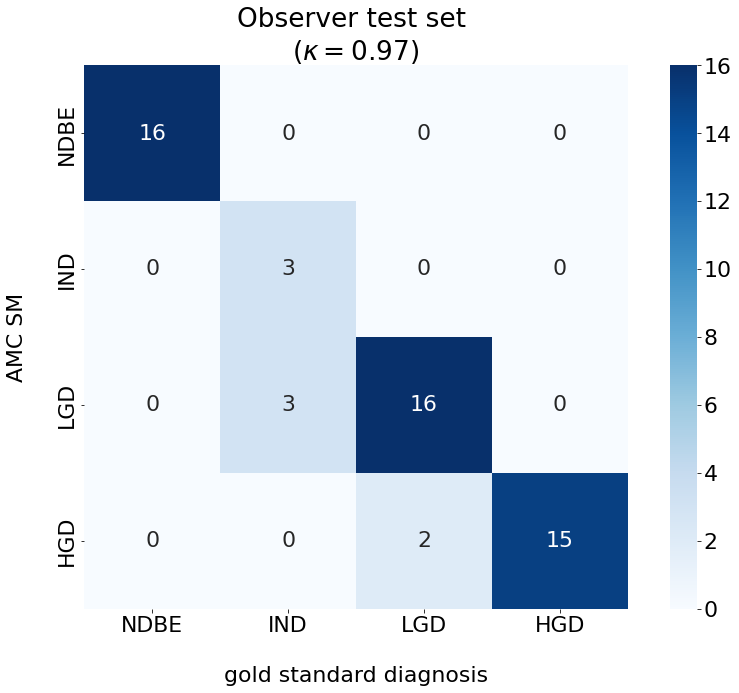

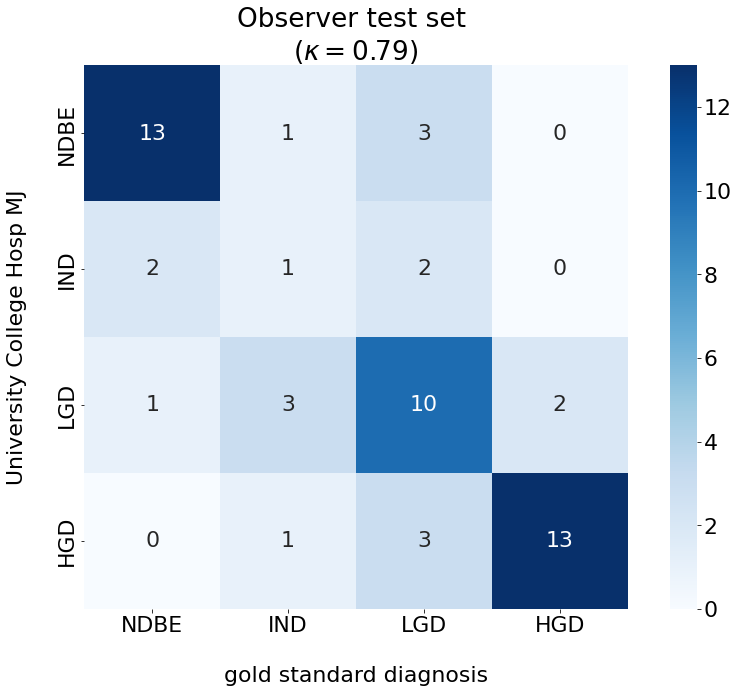

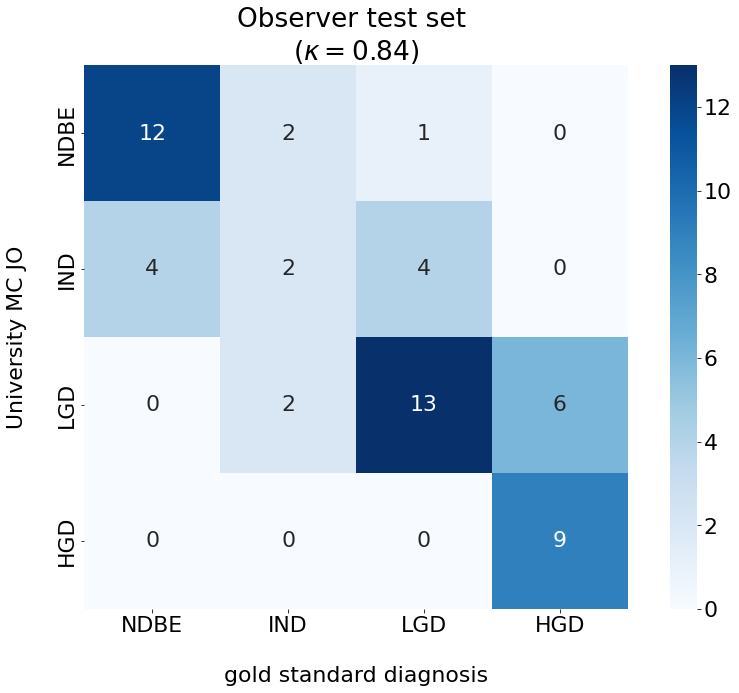

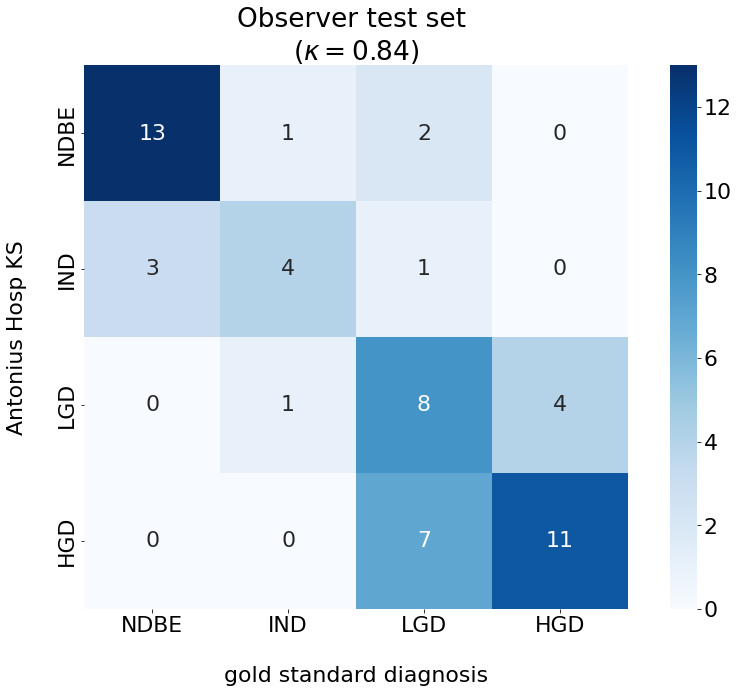

In [7]:
for rater in raters:
    y_label = rater
    x_label = 'gold standard diagnosis'
    y_true = filtered_df[y_label]
    y_pred = filtered_df[x_label]

    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    plot_confusion_matrix(cm, kappa=kappa, acc=acc, y_label=y_label, x_label=x_label)

In [8]:
for i, grade in enumerate(['NDBE', 'IND', 'LGD', 'HGD']):
    grade_df = filtered_df[filtered_df['gold standard diagnosis'] == i]
    agree_df = grade_df[(grade_df['AMC SM'] == i) &
                    (grade_df['University College Hosp MJ'] == i) &
                    (grade_df['University MC JO'] == i) &
                    (grade_df['Antonius Hosp KS'] == i)]
    print('Total agreement {}: {}/{}={:.2f}'.format(grade, len(agree_df), len(grade_df), len(agree_df) / len(grade_df)))
    # display(grade_df)

Total agreement NDBE: 8/16=0.50
Total agreement IND: 0/6=0.00
Total agreement LGD: 4/18=0.22
Total agreement HGD: 7/15=0.47


In [9]:
for i, grade in enumerate(['NDBE', 'IND', 'LGD', 'HGD']):
    accuracy_per_rater = []
    grade_df = filtered_df[filtered_df['gold standard diagnosis'] == i]
    
    for rater in raters:
        acc = accuracy_score(grade_df[rater], grade_df['gold standard diagnosis'])
        accuracy_per_rater.append(acc)
        
    print('{}: {:.2f}'.format(grade, np.mean(accuracy_per_rater)))

NDBE: 0.84
IND: 0.42
LGD: 0.65
HGD: 0.80


In [11]:
# pairwise kappa/accuracy
kappas = []
accs = []

for first_rater in raters:
    for second_rater in [rater for rater in raters if rater is not first_rater]:
        
        first_rater_grades = filtered_df[first_rater]
        second_rater_grades = filtered_df[second_rater]
        acc = accuracy_score(first_rater_grades, second_rater_grades)
        kappa = cohen_kappa_score(first_rater_grades, second_rater_grades, weights='quadratic')
        kappas.append(kappa)
        accs.append(acc)
        # cm = confusion_matrix(first_rater_grades, second_rater_grades, labels=[0, 1, 2, 3])
        # plot_confusion_matrix(cm, kappa=kappa, acc=acc, y_label=first_rater, x_label=second_rater)
        
# we got everything double now but is the same average..
print('Pair wise average kappa between raters: {:.2f}'.format(np.mean(kappas)))
print('Pair wise average accuracy between raters: {:.2f}'.format(np.mean(accs)))
print(len(kappas))

Pair wise average kappa between raters: 0.73
Pair wise average accuracy between raters: 0.58
12


In [12]:
ai_pred = pd.read_csv('/data/archief/AMC-data/Barrett/labels/bolero_AI.csv')
display(ai_pred)
ai_pred = ai_pred.rename(columns={'case': 'casus nummers'})
ai_pred = ai_pred.rename(columns={'pred': 'AI'})

filtered_df = filtered_df.merge(ai_pred, on='casus nummers')
display(filtered_df)

,case,pred
0,RB0001,3
1,RB0002,3
2,RB0003,0
3,RB0004,2
4,RB0005,0
5,RB0006,2
6,RB0007,2
7,RB0008,2
8,RB0009,3
9,RB0010,2


,casus nummers,AMC SM,University College Hosp MJ,University MC JO,Antonius Hosp KS,gold standard diagnosis,AI
0,RB0001,3,2,3,3,3,3
1,RB0002,3,3,3,3,3,3
2,RB0003,0,0,0,1,0,0
3,RB0004,3,2,2,2,2,2
4,RB0005,2,2,1,3,2,0
5,RB0006,1,2,0,0,1,2
6,RB0007,2,2,1,3,2,2
7,RB0008,2,1,2,3,2,2
8,RB0009,3,3,3,3,3,3
9,RB0010,2,1,1,3,2,2


In [ ]:
cm = np.zeros((6, 6))
all_raters = ['gold standard diagnosis'] + ['AI'] + raters

for i, first_rater in enumerate(all_raters):
    for j, second_rater in enumerate(all_raters):
        first_rater_grades = filtered_df[first_rater]
        second_rater_grades = filtered_df[second_rater]
        kappa = cohen_kappa_score(first_rater_grades, second_rater_grades, weights='quadratic')
        acc = accuracy_score(first_rater_grades, second_rater_grades)
        #print('{} first rater {} second rater {}, kappa: {}'.format((i, j), first_rater, second_rater, kappa))
        
        cm[i, j] = acc

In [ ]:
mask = np.zeros_like(cm)
mask[np.tril_indices_from(mask)] = True

labels = ['CRP', 'AI', 'P1', 'P2', 'P3', 'P4']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(15, 10))
sns.heatmap(df_cm, mask=mask, annot=True, square=True, vmax=1, cmap="Blues")
plt.yticks(rotation=0)
plt.tick_params(left=False, bottom=False) 
plt.tight_layout()
plt.savefig('plots/pairwise_concordance.png')
plt.show()

In [ ]:
# plot pairwise kappas in a boxplot
kappa_matrix_raters = cm[1:, 1:]
included_raters = ['AI','P1','P2', 'P3', 'P4']

df_plot = []

for i in range(kappa_matrix_raters.shape[0]):
    for j in range(kappa_matrix_raters.shape[1]):
        df_plot.append({'rater': included_raters[i], 'kappa': kappa_matrix_raters[i, j]})
    
df_plot = pd.DataFrame(df_plot)
df_plot = df_plot[df_plot.kappa != 1]
means = df_plot.groupby(['rater']).mean().sort_values(by='kappa', ascending=False)

# pal = 
plt.figure(figsize=(12, 8))
sns.stripplot(data=df_plot, x='kappa', y='rater', order=means.index, color='black', edgecolor='black', linewidth=2, s=10, jitter=False)
sns.boxplot(data=df_plot, x='kappa', y='rater', order=means.index, width=0.5, showmeans=True, palette='Blues_r', 
            meanprops={'marker': 'o',
                       'markerfacecolor': 'white',
                       'markeredgecolor': 'black',
                       'markersize': '20'})

plt.ylabel('Rater', labelpad=20)
plt.xlabel('Concordance', labelpad=20)
plt.savefig('plots/boxplots_AI_vs_pathologists_concordance.png')
plt.show()

In [ ]:
y_true = filtered_df['gold standard diagnosis']
y_pred = filtered_df['AI']

acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(acc)
print(kappa)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, save_path='plots/confusion_matrix_AIvsC.png', kappa=kappa, acc=acc, y_label='Consensus\nreference panel', x_label='AI')

In [ ]:
# remove IND, replace labels
df_without_ind = filtered_df[filtered_df['gold standard diagnosis'] != 1]

y_true = df_without_ind['gold standard diagnosis'].replace(2, 1).replace(3, 2)
y_pred = df_without_ind['AI'].replace(2, 1).replace(3, 2)

acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
plot_confusion_matrix(cm, save_path=None, pixel_level=False, normalized=False, kappa=kappa)

In [13]:
# lets make the full 55x56 table
columns = [2] + list(range(5, 60))
full_df = bolero_case_df.iloc[:, columns]

# NDBE => 0, IND => 1
full_df = full_df.replace(1, 0)
full_df = full_df.replace(4, 1)

# add AI predictions
ai_pred = pd.read_csv('/data/archief/AMC-data/Barrett/labels/bolero_AI.csv')
ai_pred = ai_pred.rename(columns={'case': 'casus nummers'})
ai_pred = ai_pred.rename(columns={'pred': 'AI'})
full_df = full_df.merge(ai_pred, on='casus nummers')

In [14]:
display(full_df)

,casus nummers,AMC SM,Tokyo Institute of Geront JA,General Hosp RB,UniversitÃ© de Reims C-A CB,Medical Uni of Graz IB,University MC LB,IPATIMUP FC,Kantosspital Baselland GC,CHU Amiens-Picardie DC,...,Brigham and Womens Hosp MS,Patologia Bar BG,Hosp Clin Uni EG,Leeds Hosp HG,Weill Cornell RY,University of Genova FG,Charles University KK,Universitat Bern RL,Add Hosp AC,AI
0,RB0001,3,3,1,2,2,2,3,3,1,...,3,2,0,3,3,2,2,2,3,3
1,RB0002,3,3,2,3,3,3,3,3,3,...,3,3,1,3,3,3,0,3,3,3
2,RB0003,0,0,0,0,0,1,1,0,0,...,0,2,0,0,0,0,0,0,0,0
3,RB0004,3,3,0,3,3,3,3,3,2,...,3,3,3,2,3,2,2,2,2,2
4,RB0005,2,3,2,2,1,2,1,3,3,...,2,2,0,0,1,1,2,0,2,0
5,RB0006,1,3,0,0,2,1,1,2,1,...,3,2,0,0,0,0,0,0,1,2
6,RB0007,2,3,0,0,3,2,2,3,1,...,2,3,0,1,0,2,2,1,2,2
7,RB0008,2,3,0,2,3,1,2,2,2,...,0,2,1,0,0,0,1,0,2,2
8,RB0009,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
9,RB0010,2,0,1,2,2,2,1,1,2,...,2,2,0,1,2,2,2,0,1,2


In [15]:
all_raters = full_df.columns[1:]
cm = np.zeros((len(all_raters), len(all_raters)))

for i, first_rater in enumerate(all_raters):
    for j, second_rater in enumerate(all_raters):

        first_rater_grades = full_df[first_rater]
        second_rater_grades = full_df[second_rater]
        kappa = cohen_kappa_score(first_rater_grades, second_rater_grades, weights='quadratic')
        acc = accuracy_score(first_rater_grades, second_rater_grades)

        cm[i, j] = acc

In [ ]:
# plot pairwise kappas in a boxplot
kappa_matrix_raters = cm
included_raters = all_raters

df_plot = []

for i in range(kappa_matrix_raters.shape[0]):
    for j in range(kappa_matrix_raters.shape[1]):
        if included_raters[i] == 'AI':
            df_plot.append({'rater': included_raters[i], 'kappa': kappa_matrix_raters[i, j]})
        else:
            df_plot.append({'rater': 'P{}'.format(i + 1), 'kappa': kappa_matrix_raters[i, j]})
    
df_plot = pd.DataFrame(df_plot)
df_plot = df_plot[df_plot.kappa != 1]
means = df_plot.groupby(['rater']).mean().sort_values(by='kappa', ascending=False)
display(means)


plt.figure(figsize=(30, 30))
sns.stripplot(data=df_plot, x='kappa', y='rater', order=means.index, color='black', s=6, jitter=False)
sns.boxplot(data=df_plot, x='kappa', y='rater', order=means.index, width=0.25, showmeans=True, palette='Blues_r', 
            meanprops={'marker': 'o',
                       'markerfacecolor': 'white',
                       'markeredgecolor': 'black',
                       'markersize': '15'})

plt.ylabel('Rater', labelpad=20)
plt.xlabel('Concordance', labelpad=20)
plt.tight_layout()
#plt.savefig('plots/ranking_average_pairwise_concordance_56_raters.png')
plt.show()

In [ ]:
# getting the number of agreeing patholigsts per case
agreeing_paths = []

for i, row in filtered_df.iterrows():
    gt = row['gold standard diagnosis']
    try:
        agreeing_experts = row[['AMC SM', 'University College Hosp MJ', 'University MC JO', 'Antonius Hosp KS']].value_counts()[gt]
    except:
        agreeing_experts = 0
    agreeing_paths.append(agreeing_experts)
    
filtered_df['agreeing experts'] = agreeing_paths
display(filtered_df)

In [ ]:
bolero_df = filtered_df[['casus nummers', 'gold standard diagnosis', 'agreeing experts']]
bolero_df.to_csv('/data/archief/AMC-data/Barrett/labels/bolero_w_agree.csv', index=None)

## AI vs 55 pathologist difference plots

In [27]:
all_raters = full_df.columns[1:-1]
print(len(all_raters))
full_df['gold standard diagnosis'] = filtered_df['gold standard diagnosis'].values
display(all_raters)

56


Index(['AMC SM', 'Tokyo Institute of Geront JA', 'General Hosp RB',
       'UniversitÃ© de Reims C-A CB', 'Medical Uni of Graz IB',
       'University MC LB', 'IPATIMUP FC', 'Kantosspital Baselland GC',
       'CHU Amiens-Picardie DC', 'Randers Regional Hospital PD',
       'Penrose Hosp GDP', 'Erasmus MC MD', 'Toronto General Hosp HEZ',
       'University of Padua MF', 'University of Genova RF',
       'Hopital Saint Antoine JF', 'Hospital El Bierzo AGV',
       'Imperial College RG', 'Universitair ZH Gent AH',
       'University College Hosp MJ', 'Shiga Uni of Med Science RK',
       'UniversitÃ¤tsklin Heidelberg FL', 'University Hosp Lund EL',
       'University of Genova LM', 'Belfast HSC DM', 'Diakonessenhuis AM',
       'Jena University Hosp MM', 'Johns Hopkins EM', 'St. James Hosp CM',
       'Cambridge CC MDon', 'Brigham and Womens Hosp RO', 'University MC JO',
       'Prince Charles Hosp JP', 'Mount Sinai Hosp BR',
       'Haartman Institute AR', 'University College Hosp MRJ',

In [30]:
agreement_w_consensus = []
experts = ['AMC SM', 'University College Hosp MJ', 'University MC JO', 'Antonius Hosp KS']

for i, rater in enumerate(all_raters):
    
    y_label = rater
    x_label = 'gold standard diagnosis'
    y_true = full_df[y_label]
    y_pred = full_df[x_label]  
    
    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')   
    
    if rater == 'AI':
        agreement_w_consensus.append({'rater': 'AI', 'name': rater, 'kappa': kappa, 'acc': acc, 'Rater': 'BE pathologist'})
    else:
        agreement_w_consensus.append({'rater': 'P{}'.format(i + 1), 'name': rater, 'kappa': kappa, 'acc': acc, 'Rater': 'BE pathologist' if rater in experts else 'GI pathologist'})


In [34]:
metric = 'kappa'
agreement_w_consensus_df = pd.DataFrame(agreement_w_consensus).sort_values(by=metric, ascending=True)
display(agreement_w_consensus_df)
ai_concordance = agreement_w_consensus_df[agreement_w_consensus_df['rater'] == 'AI'][metric].values

agreement_w_consensus_df['difference_with_ai'] = (ai_concordance - agreement_w_consensus_df[metric]) * 100 / ai_concordance

# to get a bar for a pathologist with the same score
#agreement_w_consensus_df.loc[27, 'difference_with_ai'] = 0.002 * 100

# to remove AI
#agreement_w_consensus_df= agreement_w_consensus_df.drop(agreement_w_consensus_df[agreement_w_consensus_df.rater == 'AI'].index)


diff_w_exp = list(agreement_w_consensus_df[agreement_w_consensus_df['Rater'] == 'BE pathologist']['difference_with_ai'])

for num in diff_w_exp:
    print('{:.2f}%'.format(num))

,rater,name,kappa,acc,Rater
38,P39,Hospital Alianca TS,0.411995,0.436364,GI pathologist
47,P48,Patologia Bar BG,0.474062,0.454545,GI pathologist
41,P42,Spedali Civil di Brescia VV,0.479935,0.527273,GI pathologist
48,P49,Hosp Clin Uni EG,0.484053,0.454545,GI pathologist
21,P22,UniversitÃ¤tsklin Heidelberg FL,0.498153,0.509091,GI pathologist
2,P3,General Hosp RB,0.551364,0.436364,GI pathologist
9,P10,Randers Regional Hospital PD,0.553813,0.454545,GI pathologist
26,P27,Jena University Hosp MM,0.560541,0.509091,GI pathologist
46,P47,Brigham and Womens Hosp MS,0.563888,0.472727,GI pathologist
25,P26,Diakonessenhuis AM,0.576312,0.527273,GI pathologist


0.00%
-1.33%
-7.88%
-7.92%
-24.21%


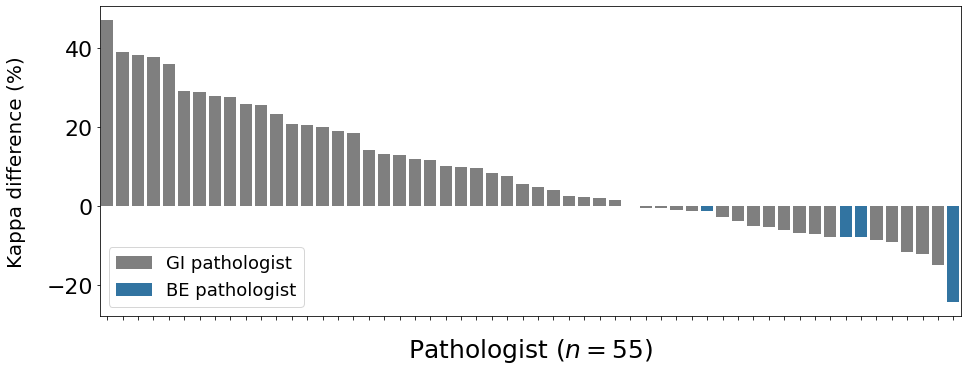

In [35]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=agreement_w_consensus_df, x='rater', y='difference_with_ai', hue='Rater', dodge=False, palette=['tab:gray', 'tab:blue'])

plt.ylabel('Kappa difference (%)', labelpad=20, fontsize=20)
plt.xlabel('Pathologist ($n=55$)', labelpad=20, fontsize=25)
plt.tight_layout()
# fig.text(s='AI system higher Kappa \n(n=51)', x=0.53, y=0.4, ha='center', fontsize=18)
# fig.text(s='Pathologist higher accuracy \n(n=4)', x=0.83, y=0.75, ha='center', fontsize=18)
plt.legend(loc='lower left', fontsize=18)
ax.tick_params(labelbottom=False)  
#plt.savefig('plots/differences_accuracy_vs_55_pathologists.png')
plt.show()

## ROC plot NDBE vs IND, LGD, HGD

In [36]:
# get AI probabilities of preds
predictions_df = pd.read_csv('/data/archief/AMC-data/Barrett/labels/predictions_df.csv')
y_prob_ai = np.asarray(predictions_df[['p_ndbe', 'p_lgd', 'p_hgd']])
y_prob_ai = np.insert(y_prob_ai, 1, 0, axis=1)

In [37]:
# prob output by the system
y_prob_nd_vs_d = np.add.reduceat(y_prob_ai, indices=[0, 2], axis=1)[:, 1]
y_true = full_df['gold standard diagnosis'] >= 1

print(y_prob_nd_vs_d.shape)
print(y_true.shape)

(55,)
(55,)


In [38]:
operating_points_pathologists = []
experts = ['AMC SM', 'University College Hosp MJ', 'University MC JO', 'Antonius Hosp KS']

for i, rater in enumerate(all_raters):
    if rater != 'AI':
        y_pred = full_df[rater] >= 1
        
        sensitivity = recall_score(y_true, y_pred)
        specificity = recall_score(y_true, y_pred, pos_label=0)
        
        operating_points_pathologists.append({'rater': 'P{}'.format(i + 1), 
                                              'name': rater, 
                                              'sensitivity': sensitivity, 
                                              'specificity': specificity,
                                              'point': (1 - specificity, sensitivity),
                                              'Rater': 'BE pathologist' if rater in experts else 'GI pathologist'})
        
op_df = pd.DataFrame(operating_points_pathologists)

In [39]:
be_ops_x = [x for (x, y) in list(op_df[op_df['Rater'] == 'BE pathologist']['point'])]
be_ops_y = [y for (x, y) in list(op_df[op_df['Rater'] == 'BE pathologist']['point'])]
gi_ops_x = [x for (x, y) in list(op_df[op_df['Rater'] == 'GI pathologist']['point'])]
gi_ops_y = [y for (x, y) in list(op_df[op_df['Rater'] == 'GI pathologist']['point'])]

specificity 100.00% at tpr of: 0.00%
specificity 100.00% at tpr of: 2.56%
specificity 100.00% at tpr of: 46.15%
specificity 93.75% at tpr of: 46.15%
specificity 93.75% at tpr of: 92.31%
specificity 68.75% at tpr of: 92.31%
specificity 68.75% at tpr of: 97.44%
specificity 37.50% at tpr of: 97.44%
specificity 37.50% at tpr of: 100.00%
specificity 0.00% at tpr of: 100.00%


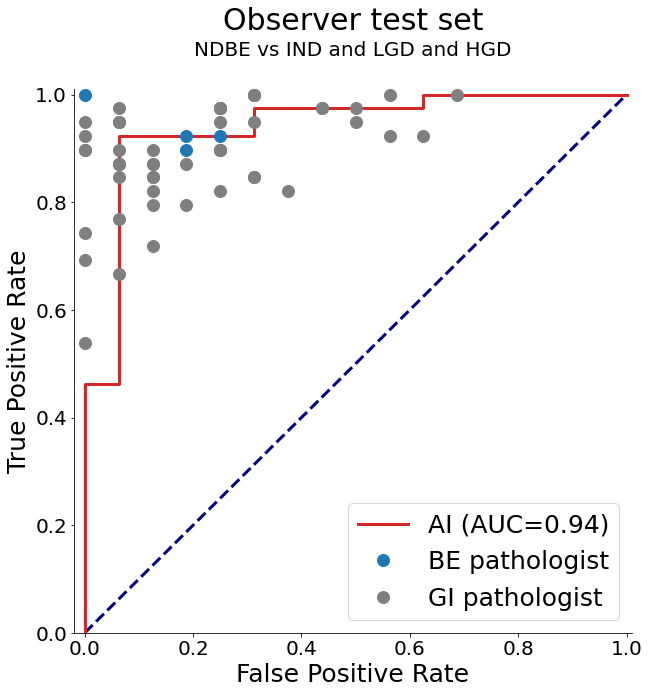

In [42]:
# compute ROC curve and ROC area for dysplasia class
fpr, tpr, _ = roc_curve(y_true, y_prob_nd_vs_d)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(10, 10))

for a, b in zip(fpr, tpr):
    print('specificity {:.2f}% at tpr of: {:.2f}%'.format((1 - a) * 100, b * 100))

ax.spines[['right', 'top']].set_visible(False)
plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")

plt.plot(
    fpr,
    tpr,
    color="tab:red",
    lw=3,
    label="{} (AUC={:.2f})".format(rater, roc_auc)
) 

plt.plot(be_ops_x, be_ops_y, color='tab:blue', marker='o', markersize=12, label='BE pathologist', linestyle='None')
plt.plot(gi_ops_x, gi_ops_y, color='tab:gray', marker='o', markersize=12, label='GI pathologist', linestyle='None')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-0.02, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate", fontsize=25)
plt.ylabel("True Positive Rate", fontsize=25)
plt.text(s="Observer test set", x=0.255, y=1.12, fontsize=30)
plt.title("NDBE vs IND and LGD and HGD", y=1.05, fontsize=20)
plt.legend(loc="lower right", fontsize=25)
#plt.savefig('plots/observer_roc_NBDE_vs_IND_LGD_HGD.png')
plt.show()

### Plot pathologist experience vs agreement with consensus, with AI in between

In [205]:
experience_df = pd.read_csv('/data/archief/AMC-data/Barrett/labels/experience_bolero.csv')
experience_df = experience_df.rename(columns={'pathologist': 'name'})
experience_df = experience_df.merge(agreement_w_consensus_df, on='name')
experience_df = experience_df.replace('0-4 years', '<4 years')
experience_df = experience_df.replace('20+ years', '>20 years')

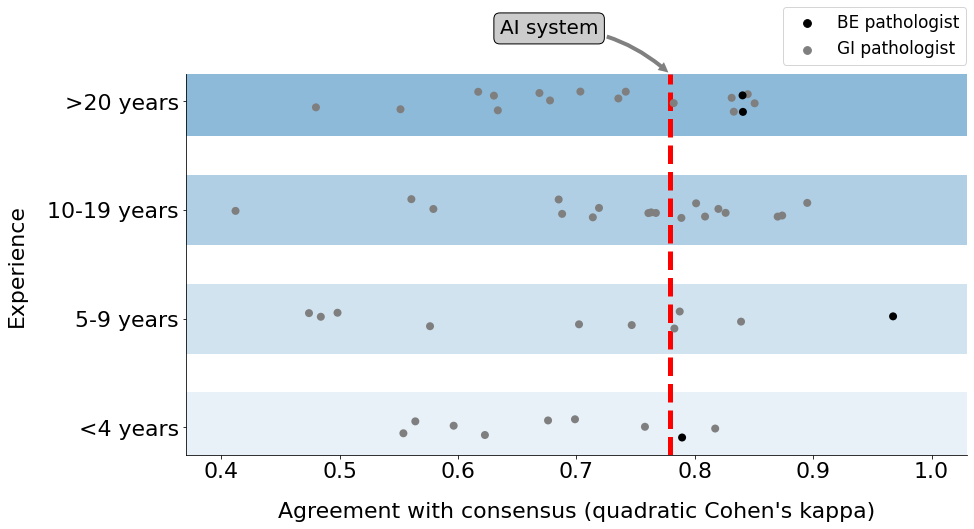

In [300]:
metric = 'kappa'
el = Ellipse((-2, 1), 0.5, 0.5)

fig, ax = plt.subplots(figsize=(14, 7))
sns.stripplot(data=experience_df, x=metric, y='years', size=8, jitter=1, hue='Rater', palette=['black', 'tab:gray'], order=reversed(['<4 years', '5-9 years', '10-19 years', '>20 years']))

sns.lineplot(x=[0.4, 1], y=[0, 0], linewidth=70, alpha=0.5, color='tab:blue')
sns.lineplot(x=[0.4, 1], y=[1, 1], linewidth=70, alpha=0.35, color='tab:blue')
sns.lineplot(x=[0.4, 1], y=[2, 2], linewidth=70, alpha=0.2, color='tab:blue')
sns.lineplot(x=[0.4, 1], y=[3, 3], linewidth=70, alpha=0.1, color='tab:blue')

# annotate the ai systems score
ai_score = agreement_w_consensus_df[agreement_w_consensus_df['rater'] == 'AI'][metric].values[0]     

ax.annotate('AI system',
            xy=(ai_score, -0.25), xycoords='data',
            xytext=(-170, 40), textcoords='offset points',
            size=20,
            bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="simple",
                            fc="0.5", ec="none",
                            patchB=el,
                            connectionstyle="arc3,rad=-0.2"))

ax.spines[['right', 'top']].set_visible(False)
metric_str = 'accuracy' if metric == 'acc' else 'quadratic Cohen\'s kappa'
plt.xlabel('Agreement with consensus ({})'.format(metric_str), labelpad=20)
plt.ylabel('Experience', labelpad=20)
plt.axvline(ai_score, linestyle='--', linewidth=5, color='red')
plt.legend(loc="upper right", fontsize=17, bbox_to_anchor=(1.01, 1.2))
plt.savefig('plots/AIvspathologist_experience_based_{}.png'.format(metric), bbox_inches='tight')
plt.show()